# Produce lifetime XY map

<i>
This notebook takes a clean kDST, measures the lifetime at
different points of the XY plane and stores this map in
a hdf5 file.
</i>

### Notebook configuration

In [1]:
run_number          = 4734
input_dst_filename  = f"$IC_DATA/Kr/dst_{run_number}_filtered.root.h5"
correction_filename = f"$IC_DATA/XYmaps/corrections_run{run_number}.h5"
plots_output_folder = f"plots/{run_number}/"

Zrange  =   80,  520
XYrange = -200,  200
Erange  =  6e3, 14e3
Znbins  =   10
XYnbins =   60
Enbins  =   50

# Plotting style
default_cmap = "jet"
figure_size  = 16, 12
font_size    = 15

save_plots   = True
with_titles  = False
plots_format = "pdf"

### Imports

In [2]:
import os
import time

import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf

from invisible_cities.core .core_functions import in_range
from invisible_cities.icaro.hst_functions  import hist
from invisible_cities.icaro.hst_functions  import labels
from invisible_cities.icaro.hst_functions  import shift_to_bin_centers
from invisible_cities.icaro.hst_functions  import poisson_sigma
from invisible_cities.icaro.hst_functions  import measurement_string

from icaro.core.fit_functions import expo_seed

%matplotlib inline

### Initialization

In [3]:
Zbins     = np.linspace(* Zrange,  Znbins+1)
Ebins     = np.linspace(* Erange,  Enbins+1)
XYbins    = np.linspace(*XYrange, XYnbins+1)

Zcenters  = shift_to_bin_centers(Zbins)

input_dst_filename  = os.path.expandvars( input_dst_filename)

### Read data

In [4]:
dst           = dstf.load_dst(input_dst_filename, "DST", "Events")
unique_events = ~dst.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 981481 
Total number of events: 975681


In [5]:
X = dst.X  .values
Y = dst.Y  .values
Z = dst.Z  .values
E = dst.S2e.values

### Fits

In [6]:
zs = []
residuals = []
for i in range(XYnbins):
    sel_x = in_range(X, *XYbins[i:i+2])
    for j in range(XYnbins):
        sel_y = in_range(Y, *XYbins[j:j+2])
        sel   = sel_x & sel_y
        z, e  = Z[sel], E[sel]
        
        if np.count_nonzero(sel) < 50: continue
        
        x, y, yu = fitf.profileX(z, e, Znbins, Zrange)
        ok       = yu > 0
        x, y, yu = x[ok], y[ok], yu[ok]

        seed     = expo_seed(x, y)
        f        = fitf.fit(fitf.expo, x, y, seed, sigma=yu)
        assert np.all(f.values != seed)
        res      = (f.fn(x) - y) / yu

        zs.extend(x)
        residuals.extend(res)

zs = np.array(zs)
residuals = np.array(residuals)

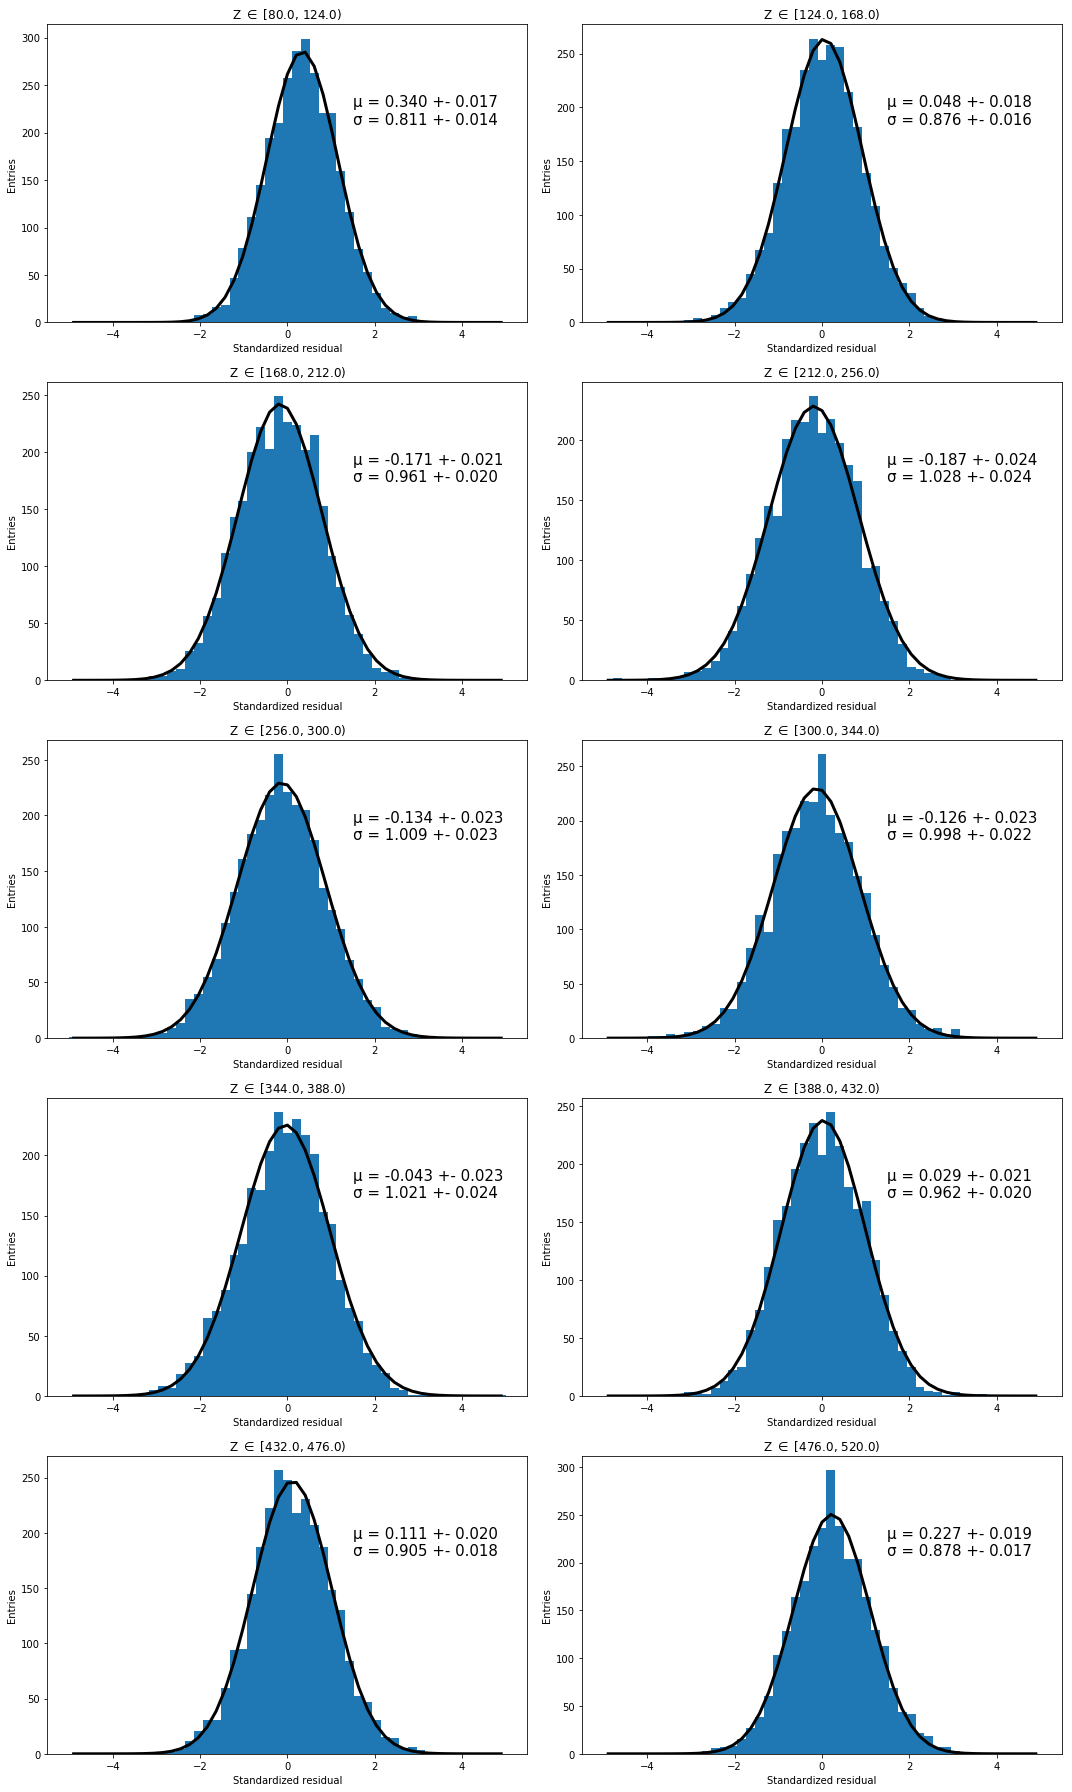

In [7]:
Rbins = np.linspace(-5, 5, 50)
mus   = np.zeros_like(Zcenters)
musu  = np.zeros_like(Zcenters)
plt.figure(figsize=(15, 25))
for i in range(Znbins):
    z0, z1 = Zbins[i:i+2]
    sel    = in_range(zs, z0, z1)
    plt.subplot(5, 2, i+1)
    y, x, _ = hist(residuals[sel], Rbins, new_figure=False)
    f = fitf.fit(fitf.gauss, x, y, (1, 0, 1), sigma=poisson_sigma(y), fit_range = (-2, 2), maxfev=10000)
    plt.plot(x, f.fn(x), "k-", lw=3)

    _, mu, sig = map(measurement_string, f.values, f.errors)
    mus[i]     = f.values[1]
    musu[i]    = f.errors[1]
    plt.text(1.5, plt.ylim()[1]/1.5, f"µ = {mu}\nσ = {sig}", fontsize=15)
    labels("Standardized residual", "Entries", f"Z $\in$ [{z0}, {z1})")
plt.tight_layout()

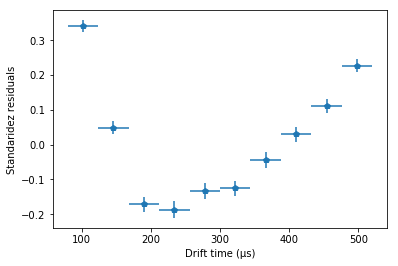

In [8]:
plt.errorbar(Zcenters, mus, musu, np.diff(Zcenters)[0]/2, "p")
labels("Drift time (µs)", "Standaridez residuals")

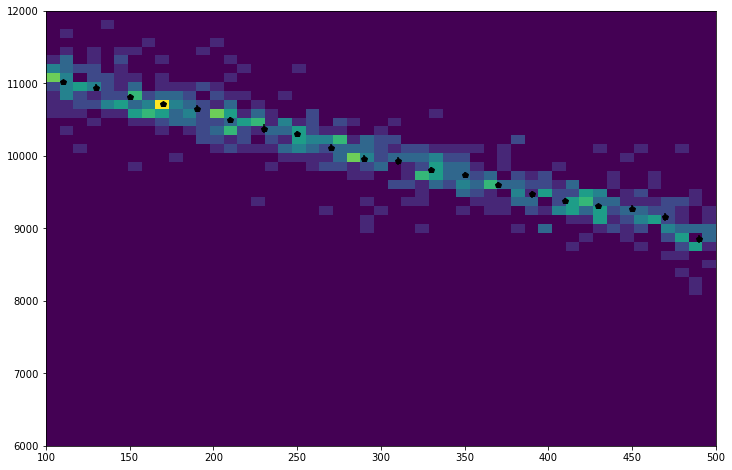

In [29]:
sel = in_range(X, 5, 15) & in_range(Y, 5, 15)
zz = Z[sel]
ee = E[sel]

from invisible_cities.icaro.hst_functions import *

plt.rcParams["figure.figsize"] = 12, 8
hist2d(zz, ee, (np.linspace(100, 500), np.linspace(6e3, 12e3)));
x, y, yu = fitf.profileX(zz, ee, 20, (100, 500), (6e3, 12e3))
plt.errorbar(x, y, yu, fmt="kp")

lts  = np.zeros(len(x)-10)
ltus = np.zeros(len(x)-10) 
for i in range(5, len(x)-5):
    f        = fitf.fit(fitf.expo, zz[i:i+5], ee[i:i+5], (1e4, -1e3))
    lts[i-5] = -f.values[1]
    ltus[i-5] =  f.errors[1]

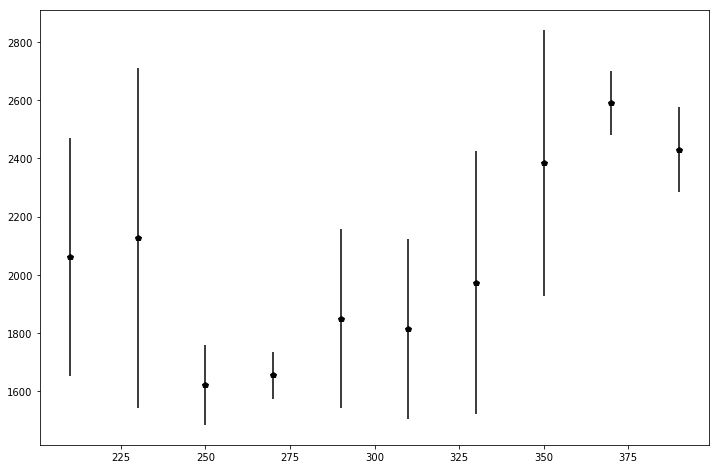

In [30]:
plt.errorbar(x[5:-5], lts, ltus, fmt="kp");